# Прогноз вероятности оттока пользователей фитнес-центра

На основе данных о посетителях сети фитнес-центров спрогнозировать вероятность оттока для каждого клиента в следующем месяце, сформировать типичные портреты пользователей и подготовить план действий по удержанию клиентов.**

**План исследования:**
1. [Загрузка данных](#open)
2. [Исследовательский анализ данных](#eda)
3. [Модель прогнозирования оттока пользователей](#model)
4. [Кластеризация пользователей](#cluster)
5. [Общие выводы и рекомендации](#conclusion)

## Шаг 1. Загрузка данных <a id='open'></a>

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter("ignore")
from IPython.display import display
import numpy as np

Прочитаем файл /datasets/gym_churn.csv и сохраним его в переменной gym_churn.

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В таблице представлены данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- **'Churn'** — факт оттока в текущем месяце;
- Текущие поля в датасете:
Данные пользователя за предыдущий до проверки факта оттока месяц:
    - **'gender'** — пол
    - **'Near_Location'** — проживание или работа в районе, где находится фитнес-центр 
    - **'Partner'** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
    - **Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
    - **'Phone'** — наличие контактного телефона
    - **'Age'** — возраст
    - **'Lifetime'** — время с момента первого обращения в фитнес-центр (в месяцах)
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
    - **'Contract_period'** — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
    - **'Month_to_end_contract'** — срок до окончания текущего действующего абонемента (в месяцах)
    - **'Group_visits'** — факт посещения групповых занятий
    - **'Avg_class_frequency_total'** — средняя частота посещений в неделю за все время с начала действия абонемента
    - **'Avg_class_frequency_current_month'** — средняя частота посещений в неделю за предыдущий месяц
    - **'Avg_additional_charges_total'** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

## Шаг 2. Исследовательский анализ данных (EDA)  <a id='eda'></a>

### Анализ пропусков, средних значений и стандартных отклонений

In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В таблице `gym_churn` 4000 строк и 14 столбцов. Пропусков в данных нет.

Поиск дубликатов.

In [5]:
gym_churn.duplicated().sum()

0

Дубликатов нет.

Для удобства разделим столбцы на две группы. Одна содержит столбцы, которые принимают только 2-3 значения, а вторая - столбцы с множеством значений.

In [6]:
columns_binar = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Churn']
columns_multi = ['Age','Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

Рассмотрим подробнее значения в столбцах.

In [7]:
# столбцы, которые принимают только 2-3 значения
for col in columns_binar:
    print('Количество уникальных значений в столбце',col,':')
    print(gym_churn[col].value_counts())
    print()

Количество уникальных значений в столбце gender :
1    2041
0    1959
Name: gender, dtype: int64

Количество уникальных значений в столбце Near_Location :
1    3381
0     619
Name: Near_Location, dtype: int64

Количество уникальных значений в столбце Partner :
0    2053
1    1947
Name: Partner, dtype: int64

Количество уникальных значений в столбце Promo_friends :
0    2766
1    1234
Name: Promo_friends, dtype: int64

Количество уникальных значений в столбце Phone :
1    3614
0     386
Name: Phone, dtype: int64

Количество уникальных значений в столбце Contract_period :
1     2207
12     960
6      833
Name: Contract_period, dtype: int64

Количество уникальных значений в столбце Group_visits :
0    2351
1    1649
Name: Group_visits, dtype: int64

Количество уникальных значений в столбце Churn :
0    2939
1    1061
Name: Churn, dtype: int64



В фитнес-центре представлены данные о 4000 клиентах. В основном его посещают посетители,которые проживают или работают рядом с фитнес-центром (3381 чел.). Причем большинство не использовали промо-код от знакомого при оплате первого абонемента (2766 чел.) и оставили данные о своем контактном номере телефона (3614 чел.). Чаще клиенты все же не посещают групповые занятия (2351 чел).

Примерно одинаковое соотношение мужчин и женщин посещают фитнес-центр (2041 и 1959 чел.), также как и практически одинаковое соотношение клиентов, являющихся сотрудниками компании-партнёра клуба (1947 чел.), и обычных клиентов фитнес-центра (2053 чел.).

Годовые абонементы купили 960 чел., а полугодовые 833 чел. Чаще всего клиенты покупают месячные абонементы (2207 чел.).

В текущем месяце прекратили посещать фитнес-центр 1061 чел.

In [8]:
# столбцы с множеством значениями
for col in columns_multi:
    print('Числовое описание данных для столбца',col,':')
    print(gym_churn[col].describe())
    print()

Числовое описание данных для столбца Age :
count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: Age, dtype: float64

Числовое описание данных для столбца Avg_additional_charges_total :
count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: Avg_additional_charges_total, dtype: float64

Числовое описание данных для столбца Month_to_end_contract :
count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: Month_to_end_contract, dtype: float64

Числовое описание данных для столбца Lifetime :
count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max  

Средний возраст клиентов фитнес-центра 29 лет, со стандартным отклонением равным 3.
Средняя суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон, равна 136,2, со стандартным отклонением 96,4.
Чаще срок до окончания текущего действующего абонемента составляет 1 месяц, скорее всегоэто потому, что в основном покупают именно месячные абонементы.
В среднем время с момента первого обращения в фитнес-центр составляет 3 месяца.

Средняя частота посещений в неделю за все время с начала действия абонемента также как и средняя частота посещений в неделю за предыдущий месяц составляет примерно 2 раза в неделю с отклонением равным 1.

### Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

Выведем статистику по средним значениям признаков по группам.

In [9]:
gym_churn.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [10]:
gym_churn.groupby('Churn').median()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,1,1,1,0,1,6,0,30,149.881171,6.0,4,2.043252,2.046697
1,1,1,0,0,1,1,0,27,103.814686,1.0,1,1.491187,0.979445


Для клиентов, ушедших в отток характерны:
    - более молодой средний возраст - 27 лет;
    - меньшая суммарная выручка от других услуг фитнес-центра;
    - длительность абонемента в среднем составляет 1 месяц;
    - среднее время с момента первого обращения в фитнес-центр составляет 1 месяц;
    - средняя частота посещений фитнес-центра 1 раз в неделю;
    - в равной степени прекращают ходить в фитнес-центр и мужчины, и женщины.
    
Для клиентов, оставшихся в фитнес-центре характерны:
    - средний возраст клиентов 30 лет;
    - бОльшая средняя выручка от других услуг фитнес-центра;
    - длительность абонемента в среднем составляет 6 месяцев;
    - среднее время с момента первого обращения в фитнес-центр составляет 4 месяца;
    - средняя частота посещений фитнес-центра 2 раза в неделю;
    - они чаще посещяют групповые занятия, чем те кто ушел в отток.

### Построение столбчатых гистограмм и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

Для наглядности можно предмтавить разницу в поведение клиентов тех, кто ушёл (выделим красным цветом) и тех, кто остался (синий цвет), графически. Построим гистограммы.

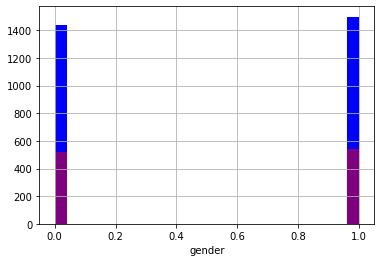

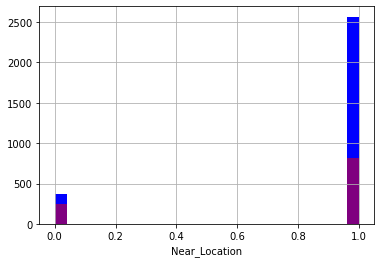

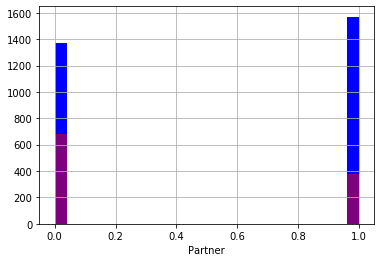

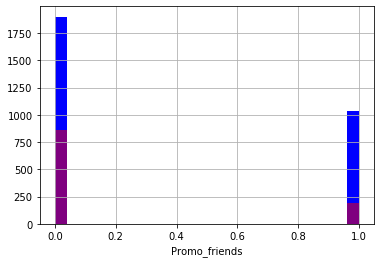

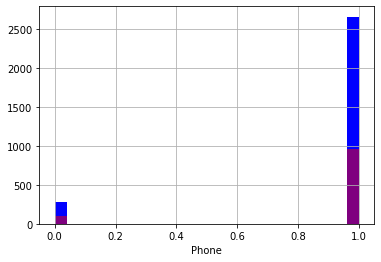

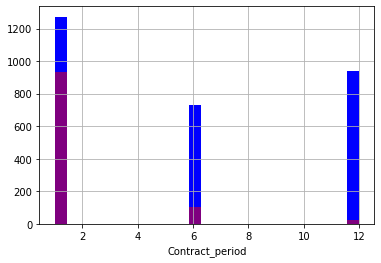

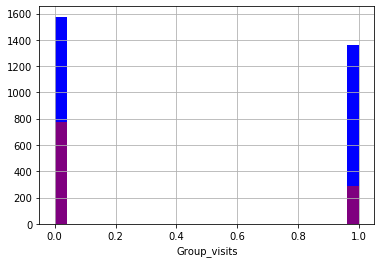

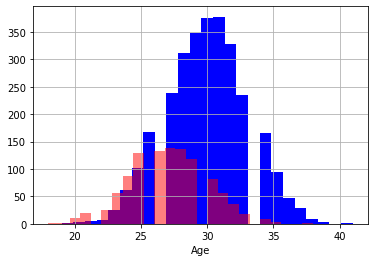

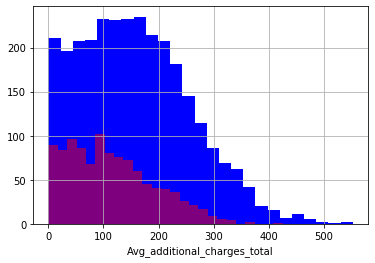

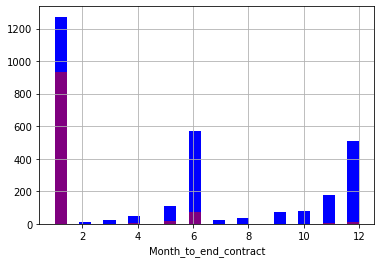

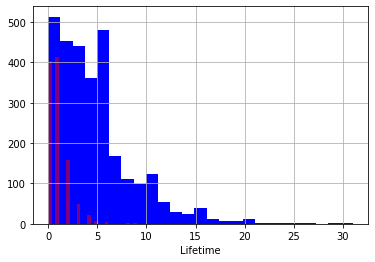

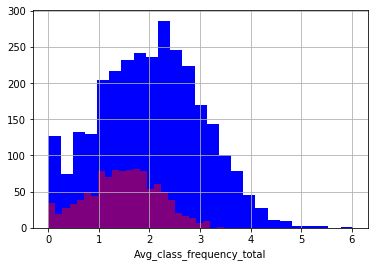

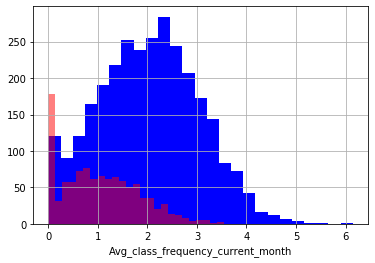

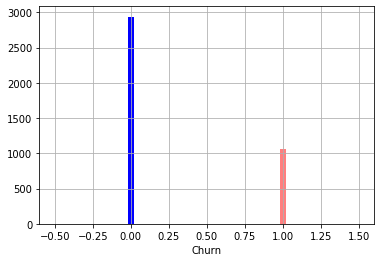

In [11]:
# строим гистограммы для каждого признака
for hist in gym_churn.columns:
    gym_churn.query('Churn ==0')[hist].hist(bins=25, color='blue')
    gym_churn.query('Churn !=0')[hist].hist(bins=25,color='red',alpha=0.5)
    plt.xlabel(hist)
    plt.show()

Соответственно, по графикам можно сделать те же выводы, что и были сделаны выше на основании средних значений.  

### Матрица корреляций

Посттроим хитмап для матрицы корреляций датафрейма `gym_churn`.

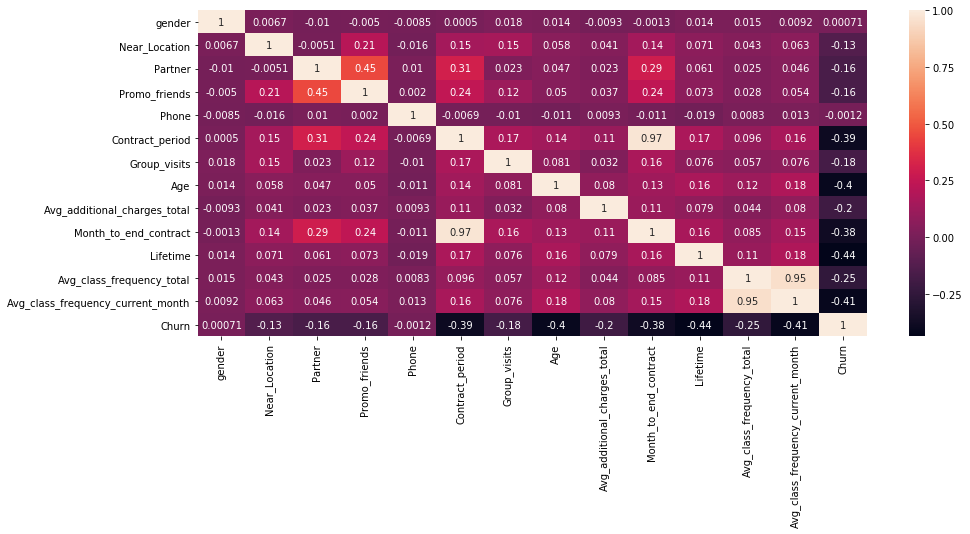

In [12]:
plt.figure(figsize=(15, 6))
sns.heatmap(gym_churn.corr(), annot = True, fmt='.2g')
plt.show()

Признаки 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента, и 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц, сильно коррелируют друг с другом.
Признаки 'Contract_period' — длительность текущего действующего абонемента, и 'Month_to_end_contract' — срок до окончания текущего действующего абонемента, также сильно коррелируют друг с другом. Это и не удивительно, так как они явно взаимосвязаны. Поэтому исключим по одному признаку из каждой коррелирующей пары.

In [13]:
# удаляем столбцы 'Avg_class_frequency_total' и 'Month_to_end_contract' из таблицы gym_churn
gym_churn = gym_churn.drop(['Avg_class_frequency_total','Month_to_end_contract'],axis=1)
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(2), int64(10)
memory usage: 375.1 KB


Строим заново хитмап матрицы корреляций.

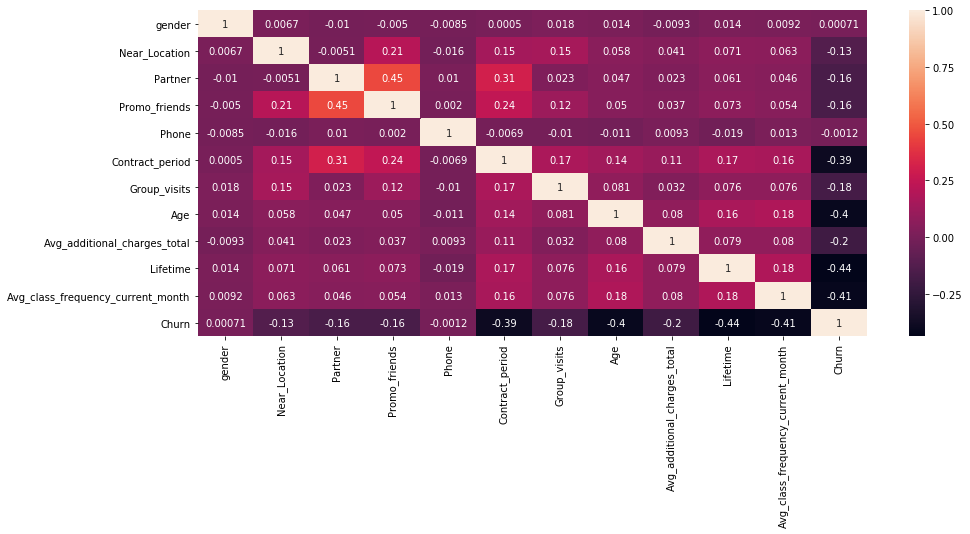

In [14]:
plt.figure(figsize=(15, 6))
sns.heatmap(gym_churn.corr(), annot = True, fmt='.2g')
plt.show()

Заметим, что более всего `Churn` коллерирует с признаками `Lifetime`, `Avg_class_frequency_current_month`, `Age`, `Contract_period` (обратная зависимость).

Скорректируем группу столбцов с непрерывными значениями.

In [15]:
columns_multi = ['Age','Avg_additional_charges_total', 'Lifetime','Avg_class_frequency_current_month']

## Шаг 3. Модель прогнозирования оттока пользователей  <a id='model'></a>

Рассмотрим, как соотносятся классы для нашего набора данных

In [16]:
size = gym_churn.groupby('Churn')['gender'].count().reset_index().rename(columns={'gender':'count'})
size['%'] = (size['count']*100/(size['count'].sum())).round(1)
size

,Churn,count,%
0,0,2939,73.5
1,1,1061,26.5


26.5% пользователей прекратило посещать фитнес-центр. Рассматриваемые классы несбалансированы 73,5% : 26,5%.

Разделим наши данные на признаки (матрица X) и целевую переменную (y)

In [17]:
X = gym_churn.drop('Churn', axis = 1)
y = gym_churn['Churn']

Разделяем модель на обучающую и валидационную выборку

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Логистическая регрессия**

Зададим алгоритм для модели логистической регрессии.


In [19]:
lr_model = LogisticRegression(random_state = 0)

Обучим модель.


In [20]:
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Воспользуемся уже обученной моделью, чтобы сделать прогнозы.


In [21]:
lr_predictions = lr_model.predict(X_test)

**Случайный лес**

Зададим алгоритм для новой модели на основе алгоритма случайного леса.


In [22]:
rf_model = RandomForestClassifier(n_estimators = 100,random_state = 0) 

Обучим модель случайного леса.


In [23]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Воспользуемся уже обученной моделью, чтобы сделать прогнозы.


In [24]:
rf_predictions = rf_model.predict(X_test)

### Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке

Определим функцию, которая будет выводить метрики.


In [25]:
# на вход функция принимает верные и спрогнозированные значения на валидационной выборке, а также заголовок.
def print_all_metrics(y_true, y_pred, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

Выведем метрики для обеих моделей.


In [26]:
print_all_metrics(y_test, lr_predictions, 'Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.79


In [27]:
print_all_metrics(y_test, rf_predictions, 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75


Аccuracy - это доля верно угаданных ответов из всех прогнозов. Чем ближе значение к 100%, тем лучше. Аccuracy работает не всегда, а только при условии баланса классов — когда объектов каждого класса примерно поровну. В нашем случае Accuracy для двух моделей равен 0.9, но классы несбалансированы, поэтому целесообразно оценить модели без привязки к соотношению классов. Для этого рассчитали метрики: precision - доля правильных ответов только среди целевого класса, и recall - показывает, сколько реальных объектов нужного класса мы смогли обнаружить с помощью модели. Precision выше для модели случайного леса (0,81), а Recall выше для модели логистической регрессии (0,79).

Для прогнозирования оттока пользователей фитнес-клуба более полезна метрика recall. Лучше направить дополнительные меры по удержанию клиента и узнать, что тревога была ложной, чем потерять клиента.

На основании полученных метрик, можно сказать, что в нашем случае модель логистической регрессии показала себя лучше.

## Шаг 4. Кластеризация пользователей  <a id='cluster'></a>

### Стандартизация данных


Cтандартизируем данные.

In [28]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Построение матрицы расстояний функцией linkage() на стандартизованной матрице признаков и отрисовка дендрограммы

Передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage().

In [29]:
linked = linkage(X_sc, method = 'ward')

В переменной linked сохранена таблица «связок» между объектами. Её можно визуализировать как дендрограмму:

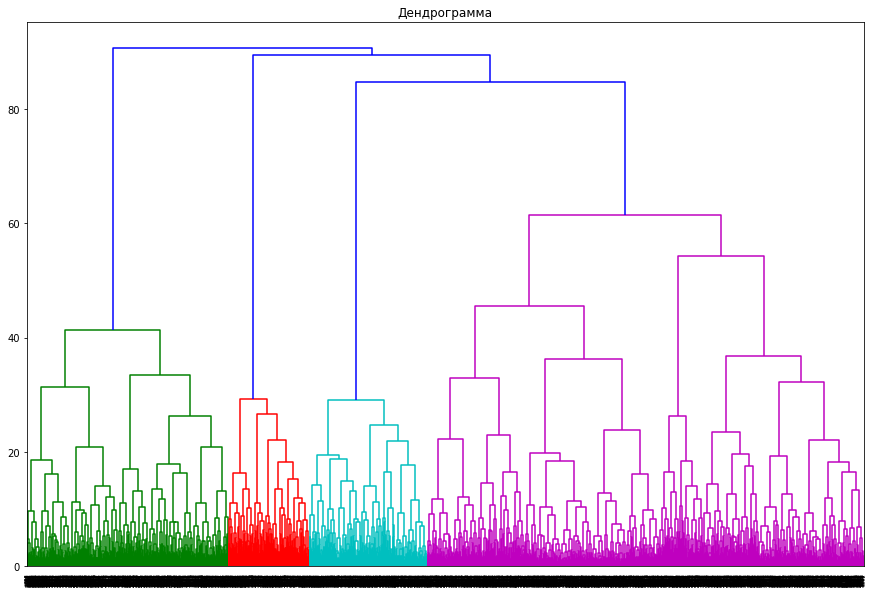

In [30]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show()

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике.

### Обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров клиентов

Задаём модель k_means с числом кластеров 5

In [31]:
km = KMeans(n_clusters = 5,random_state=0)

Спрогнозируем кластеры для наблюдений.

In [32]:
labels =  km.fit_predict(X_sc)

Сохраним метки кластера в датафрейме `gym_churn`.

In [33]:
gym_churn['cluster_km'] = labels

### Средние значения признаков для кластеров

Выведем статистику по средним значениям признаков по кластеру.

In [34]:
display(gym_churn.groupby('cluster_km').mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


In [35]:
gym_churn.groupby('cluster_km').median()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,
0,0.0,1.0,1.0,1.0,1.0,6.0,1.0,30.0,148.052829,3.0,1.901030,0.0
1,0.5,0.0,0.0,0.0,1.0,1.0,0.0,29.0,124.210124,2.0,1.503095,0.0
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,28.0,106.899036,1.0,1.136017,1.0
3,1.0,1.0,0.0,0.0,1.0,6.0,1.0,31.0,169.251037,4.0,2.383973,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,29.0,137.016545,3.0,1.657683,0.0


По этим данным можно сразу заметить, что наиболее часто прекращают посещать фитнес-центр клиенты, отнесенные ко 2-му кластеру. В 3-ом кластере самые постоянные клиенты фитнес-центра (длительный период абонемента, частая посещаемость фитнес-центра, меньший отток клиентов).

### Построение распределений признаков для кластеров

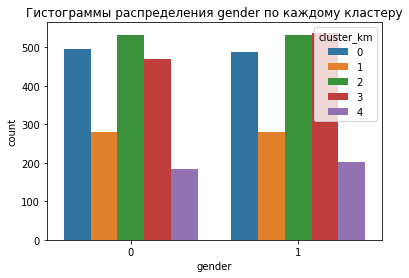

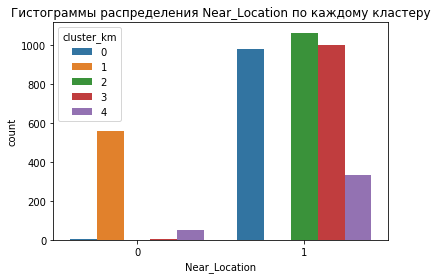

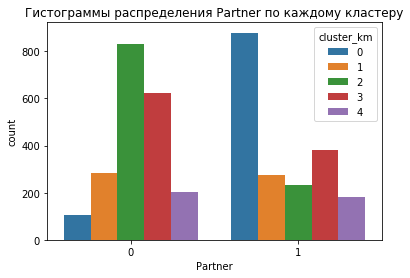

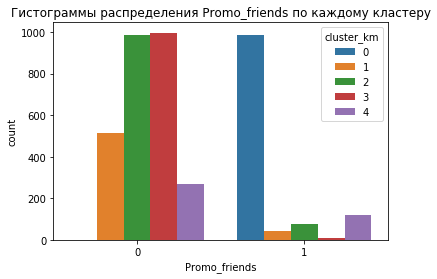

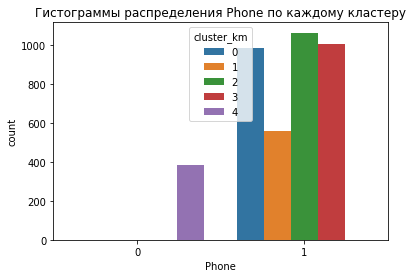

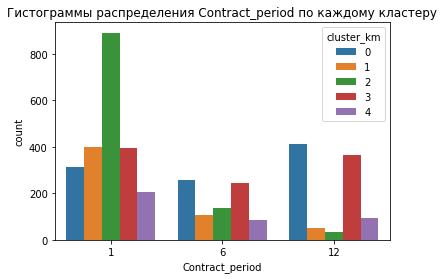

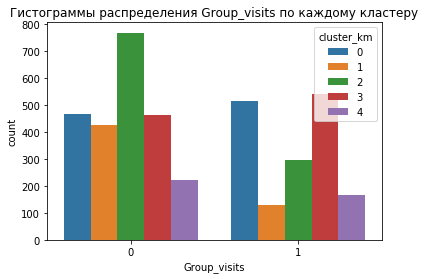

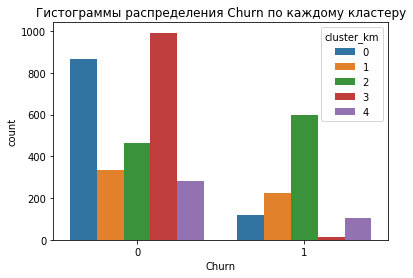

In [36]:
# отрисовка графиков для столбцов, которые принимают только 2-3 значения
for col in columns_binar:
    plt.title('Гистограммы распределения '+col+' по каждому кластерy')
    sns.countplot(x=col, hue="cluster_km", data=gym_churn)   
    plt.show()


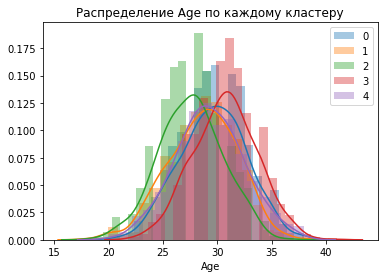

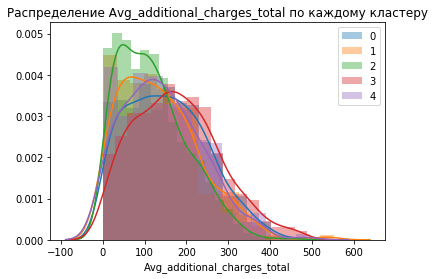

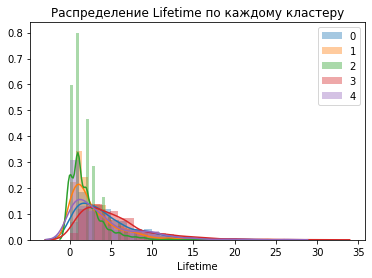

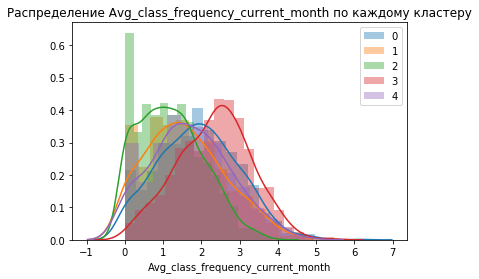

In [37]:
# отрисовка графиков для непрерывного признака
for col in columns_multi:
    for i in np.sort(gym_churn['cluster_km'].unique()): 
        sns.distplot(gym_churn.query('cluster_km == @i')[col], label=i)
        plt.legend(loc='upper right')
    plt.title('Распределение '+col+' по каждому кластерy')
    plt.show()

Кластер 0. Характерные признаки:
    - в кластере в основновном представлены сотрудники компании-партнёра клуба;
    - в кластере в основном клиенты, которые использовали промо-код от знакомого при оплате первого абонемента; 
    - проживание или работа в районе, где находится фитнес-центр;
    - небольшой отток пользователей.
Кластер 1. Характерные признаки:
    - в основном клиенты, которые проживают или работают далеко от фитнес-центра;
    - в основном клиенты, которые не использовали промо-код от знакомого при оплате первого абонемента; 
    - малое время с момента первого обращения в фитнес-центр;
    - чаще посещают групповые занятия;
    - небольшая суммарная выручка от других услуг фитнес-центра.
Кластер 2. Характерные признаки:
    - проживание или работа в районе, где находится фитнес-центр;
    - чаще не сотрудники компании-партнёра клуба;
    - в основном клиенты, которые не использовали промо-код от знакомого при оплате первого абонемента; 
    - более молодой средний возраст;
    - меньшая суммарная выручка от других услуг фитнес-центра;
    - большой отток пользователей;
    - небольшой Lifetime;
    - редкая посещаемость фитнес-центра.
Кластер 3. Характерные признаки:
    - проживание или работа в районе, где находится фитнес-центр ;
    - малый отток пользователей;
    - более старший средний возраст;
    - бОльшая суммарная выручка от других услуг фитнес-центра;
    - более длительный Lifetime;
    - чаще посещают фитнес-центр.
Кластер 4. Характерные признаки:
    - отсутствует контактный телефон.

### Доля оттока для каждого полученного кластера 

Найдем долю оттока для каждого кластера.

In [38]:
# группируем данные по кластерам и находим процент оттока
churn_proportion = gym_churn.groupby('cluster_km').agg({'Churn':['count','sum']}).reset_index()
churn_proportion.columns = ['cluster_km','сlients','outflow']
churn_proportion['proportion_outflow'] = ((churn_proportion['outflow'] / churn_proportion['сlients'])*100).round(1)
churn_proportion

,cluster_km,сlients,outflow,proportion_outflow
0,0,985,118,12.0
1,1,558,225,40.3
2,2,1064,600,56.4
3,3,1007,15,1.5
4,4,386,103,26.7


Более склонны к оттоку кластеры 2 (56,4%) и 1 (40,3%). Самый надежный кластер 3 (процент оттока 1,5), достаточно надежен и кластер 0.

## Шаг 5. Общие выводы и  рекомендации  <a id='conclusion'></a>

В фитнес-центре представлены данные о 4000 клиентах. В основном его посещают посетители,которые проживают или работают рядом с фитнес-центром (3381 чел.). Причем большинство не использовали промо-код от знакомого при оплате первого абонемента (2766 чел.) и оставили данные о своем контактном номере телефона (3614 чел.). Чаще клиенты все же не посещают групповые занятия (2351 чел).
Примерно одинаковое соотношение мужчин и женщин посещают фитнес-центр (2041 и 1959 чел.), также как и практически одинаковое соотношение клиентов, являющихся сотрудниками компании-партнёра клуба (1947 чел.), и обычных клиентов фитнес-центра (2053 чел.).

Годовые абонементы купили 960 чел., а полугодовые 833 чел. Чаще всего клиенты покупают месячные абонементы (2207 чел.). В текущем месяце прекратили посещать фитнес-центр 1061 чел. это составляет 26,5% всех клиентов.

Средний возраст клиентов фитнес-центра 29 лет. Средняя суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон, равна 136,2. Чаще срок до окончания текущего действующего абонемента составляет 1 месяц, скорее всегоэто потому, что в основном покупают именно месячные абонементы. В среднем время с момента первого обращения в фитнес-центр составляет 3 месяца.

Средняя частота посещений в неделю за все время с начала действия абонемента также как и средняя частота посещений в неделю за предыдущий месяц составляет примерно 2 раза в неделю.


Для клиентов, ушедших в отток характерны:
    - более молодой средний возраст - 27 лет;
    - меньшая суммарная выручка от других услуг фитнес-центра;
    - длительность абонемента в среднем составляет 1 месяц;
    - среднее время с момента первого обращения в фитнес-центр составляет 1 месяц;
    - средняя частота посещений фитнес-центра 1 раз в неделю;
    - в равной степени прекращают ходить в фитнес-центр и мужчины, и женщины.
    
Для клиентов, оставшихся в фитнес-центре характерны:
    - средний возраст клиентов 30 лет;
    - бОльшая средняя выручка от других услуг фитнес-центра;
    - длительность абонемента в среднем составляет 6 месяцев;
    - среднее время с момента первого обращения в фитнес-центр составляет 4 месяца;
    - средняя частота посещений фитнес-центра 2 раза в неделю;
    - они чаще посещяют групповые занятия, чем те кто ушел в отток.
    
Заметим, что более всего отток коллерирует с признаками Lifetime - время с момента первого обращения в фитнес-центр, Avg_class_frequency_current_month - средняя частота посещений в неделю за предыдущий месяц, Age - возраст, Contract_period - длительность текущего действующего абонемента (обратная зависимость по всем признаками).


В ходе анализа были построены две модели бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце. Обучение модели осуществлялось двумя способами: логистической регрессией и случайным лесом. Проведена оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке. В нашем случае Accuracy для двух моделей равен 0.9, но классы несбалансированы, поэтому целесообразно оценить модели без привязки к соотношению классов. Для этого рассчитали метрики: precision - доля правильных ответов только среди целевого класса, и recall - показывает, сколько реальных объектов нужного класса мы смогли обнаружить с помощью модели. Precision выше для модели случайного леса (0,81), а Recall выше для модели логистической регрессии (0,79).

Для прогнозирования оттока пользователей фитнес-клуба более полезна метрика recall. Лучше направить дополнительные меры по удержанию клиента и узнать, что тревога была ложной, чем потерять клиента. На основании полученных метрик, можно сказать, что в нашем случае модель логистической регрессии показала себя лучше.


Далее проведено обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров клиентов. За число кластеров принято n=5. Получили следующие выводы по кластерам.

Кластер 0. Характерные признаки:
    - в кластере в основновном представлены сотрудники компании-партнёра клуба;
    - в кластере в основном клиенты, которые использовали промо-код от знакомого при оплате первого абонемента; 
    - проживание или работа в районе, где находится фитнес-центр;
    - небольшой отток пользователей.
Кластер 1. Характерные признаки:
    - в основном клиенты, которые проживают или работают далеко от фитнес-центра;
    - в основном клиенты, которые не использовали промо-код от знакомого при оплате первого абонемента; 
    - малое время с момента первого обращения в фитнес-центр;
    - чаще посещают групповые занятия;
    - небольшая суммарная выручка от других услуг фитнес-центра.
Кластер 2. Характерные признаки:
    - проживание или работа в районе, где находится фитнес-центр;
    - чаще не сотрудники компании-партнёра клуба;
    - в основном клиенты, которые не использовали промо-код от знакомого при оплате первого абонемента; 
    - более молодой средний возраст;
    - меньшая суммарная выручка от других услуг фитнес-центра;
    - большой отток пользователей;
    - небольшой Lifetime;
    - редкая посещаемость фитнес-центра.
Кластер 3. Характерные признаки:
    - проживание или работа в районе, где находится фитнес-центр ;
    - малый отток пользователей;
    - более старший средний возраст;
    - бОльшая суммарная выручка от других услуг фитнес-центра;
    - более длительный Lifetime;
    - чаще посещают фитнес-центр.
Кластер 4. Характерные признаки:
    - отсутствует контактный телефон.   
    
Более склонны к оттоку кластеры 2 (56,4%) и 1 (40,3%). Самый надежный кластер 3 (процент оттока 1,5), достаточно надежен и кластер 0.

**Рекомендации по снижению оттока:**

    - проводить акции, направленные на заключение более долгих договоров и посещение фитнес-центра компанией. Чем дольше длительность текущего действующего абонемента, тем надежнее клиент. Чаще более длительные договара заключаются в рамках акций «приведи друга» или взаимодействия с сотрудниками компании-партнёра клуба.
    - рассмотреть возможность открытия сети фитнес-центров. Клиенты в основнов посещают фитнес-центры, если они расположены в районе проживания или работы. 
    - вести политику, направленную на удержание клиентов. Чем дольше времени проходит с момента первого обращения в фитнес-центр, тем надежнее клиент. 
    - мотивировать клиента,который ходит реже 2-х раз в неделю в фитнес-центр; возможно, давать бонусы клиентам, часто посещающим фитнес-центр. Средняя частота посещений в неделю заметно влияет на уменьшение оттока.
    - обратить внимание, что клиенты в возрасте около 30 лет менее склонны к оттоку, чем более молодые клиенты.